<a href="https://colab.research.google.com/github/wincmoriya/pytorch-handson/blob/main/MLP%E3%81%AB%E3%82%88%E3%82%8BMNIST%E3%81%AE%E5%88%86%E9%A1%9E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
# データ可視化ライブラリ、matplotlibが内部で動いている
import seaborn as sns
# 一般的に使用されるデータセットが簡単にダウンロードできるオプションが付属している
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
device

'cuda'

In [8]:
# 前処理の定義をする
# 
transform = transforms.Compose([
    # 画像をtensorクラスに変換する
    # チャネルラストをチャネルファーストに変換する
    # 0~255の値を0~1に変換する
    transforms.ToTensor()
])
# MNISTのデータをダウンロード
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [10]:
# ミニバッチの数を100に設定する
num_batche = 100

In [11]:
# dataloaderの作成
train_dataloader = DataLoader(train_dataset, batch_size=num_batche, shuffle=True)

In [17]:
# train_dataloaderから100個取得して画像データを見てみる
# イテレータに変換することで要素を最初から順番に取り出すことができる機能
# 要素を取り出すときにはnext()を使う
train_iter = iter(train_dataloader)

In [18]:
# dataloaderはimgsとlabelの二つの値を返す
imgs, labels = train_iter.next()

In [21]:
# 100はnum_batcheで指定したミニバッチの次元が来ている
# グレースケールなのでチャネルに1が入っている
# H,Wという順番で28*28の画像であるということがわかる
imgs.size()

torch.Size([100, 1, 28, 28])

In [23]:
# labelsには分類の教師データが入っている
labels

tensor([5, 4, 3, 6, 7, 2, 9, 3, 6, 0, 4, 6, 7, 4, 5, 5, 9, 4, 3, 9, 6, 7, 5, 0,
        5, 2, 0, 2, 5, 7, 8, 9, 4, 2, 7, 1, 2, 7, 7, 2, 8, 8, 0, 4, 1, 9, 3, 6,
        9, 6, 1, 1, 0, 1, 0, 7, 1, 4, 4, 5, 7, 7, 2, 4, 1, 6, 8, 7, 5, 2, 6, 8,
        2, 2, 3, 7, 8, 0, 7, 2, 4, 6, 0, 1, 0, 3, 3, 8, 6, 7, 7, 5, 5, 3, 5, 7,
        6, 5, 3, 0])

In [25]:
# imgsの画像の最初をimgで保存する
img = imgs[0]

In [26]:
# 画像に戻すためにはチャネルラストに変換する
img_permute = img.permute(1, 2, 0)

In [28]:
# ValueError: Must pass 2-d input. shape=(28, 28, 1)
# 2次元のarrayを渡す必要がある
sns.heatmap(img_permute)

ValueError: ignored

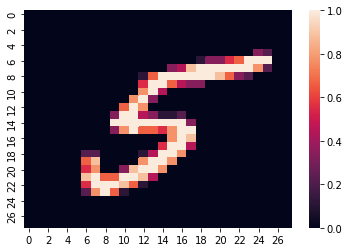

In [30]:
# 2次元配列に戻す
sns.heatmap(img_permute.numpy()[:, :, 0])

In [31]:
labels[0]

tensor(5)

# モデルを作成する

In [32]:
class MLP(nn.Module):
    def __init__(self):
        # 親クラスの初期化
        super().__init__()
        # ネットワークの構築
        self.classifier = nn.Sequential(
            # 28*28の1次元化された入力次元を与える
            # 出力次元(out_features)は
            nn.Linear(28 * 28, 400),
            # inplace=Trueで元の値を置き換える
            nn.ReLU(inplace=True),
            nn.Linear(400, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
        )
    def forward(self, x):
        output = self.classifier(x)
        return output

In [33]:
model = MLP()

In [35]:
model.to(device)

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [37]:
# 損失関数の設定を行う, 他クラス分類なのでクロスエントロピーを用いる
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [38]:
num_epochs = 15
losses = []
accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    # ミニバッチのループ
    # 100個ずつの画像とラベルを返す
    for imgs, labels in train_dataloader:
        # imgsをviewを使って数値に変換する
        imgs = imgs.view(num_batche, -1)
        imgs = imgs.to(device)
        labels = labels.to(device)
        # optim勾配の初期化
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        running_loss += loss.item()
        # outputをargmax関数に渡して分類方向の軸でoutputの値が最大の場所を返すようにする
        # dim=0の場合バッチ方向、dim=1の場合0~9の分類方向
        pred = torch.argmax(output, dim=1)
        # torch.meanがpred.eq(labels)と等しいかどうか判定
        # floatにしないと平均値を返すときにエラーが出る
        running_acc += torch.mean(pred.eq(labels).float())
        loss.backward()
        # 重みの更新を行う
        optimizer.step()
    # data_loaderの大きさを割り算して平均値にする必要がある
    # 60000個のデータを100個刻みにしているので全部で600回ループがまわる→その間プラスになり続けるので平均するには600で割る必要がある
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)
    print("epoch: {}, loss: {}, acc: {}".format(epoch, running_loss, running_acc))

epoch: 0, loss: 0.31032609374572834, acc: 0.9099677801132202
epoch: 1, loss: 0.10514932334733507, acc: 0.9682325720787048
epoch: 2, loss: 0.07178614072967321, acc: 0.9773321747779846
epoch: 3, loss: 0.05041796006844379, acc: 0.9845318794250488
epoch: 4, loss: 0.0390450580813922, acc: 0.9872986078262329
epoch: 5, loss: 0.031183607139197798, acc: 0.9895650744438171
epoch: 6, loss: 0.026335937357798683, acc: 0.9915322065353394
epoch: 7, loss: 0.023997261667391287, acc: 0.9919155240058899
epoch: 8, loss: 0.01742211791635782, acc: 0.9941983222961426
epoch: 9, loss: 0.019986492175715586, acc: 0.9933152794837952
epoch: 10, loss: 0.014322856256058003, acc: 0.9955654144287109
epoch: 11, loss: 0.015673772507895287, acc: 0.9948155879974365
epoch: 12, loss: 0.012816479944794991, acc: 0.9956984519958496
epoch: 13, loss: 0.011195798100150872, acc: 0.9962487816810608
epoch: 14, loss: 0.011633252825243592, acc: 0.9962490797042847


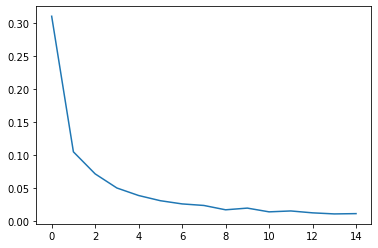

In [39]:
plt.plot(losses)

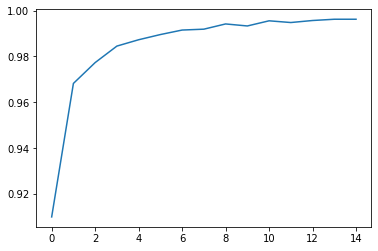

In [40]:
plt.plot(accs)

In [41]:
# 試しに分類してみる
train_iter = iter(train_dataloader)

In [43]:
imgs, labels = train_iter.next()

In [44]:
# 実際のラベル
labels

tensor([1, 2, 7, 3, 2, 3, 4, 8, 0, 7, 0, 4, 3, 3, 4, 7, 7, 6, 8, 8, 3, 5, 1, 1,
        4, 1, 6, 2, 6, 9, 7, 3, 0, 0, 6, 7, 0, 8, 4, 7, 2, 9, 5, 3, 6, 1, 3, 6,
        1, 3, 6, 0, 7, 1, 2, 9, 0, 8, 9, 3, 8, 4, 2, 4, 3, 1, 3, 4, 1, 2, 6, 0,
        9, 6, 3, 9, 7, 5, 4, 4, 3, 6, 6, 8, 1, 1, 6, 7, 7, 8, 6, 0, 0, 7, 9, 0,
        0, 5, 7, 5])

In [47]:
imgs_gpu = imgs.view(100, -1).to(device)
output = model(imgs_gpu)

In [48]:
# argmax最大の値を返す関数は
pred  = torch.argmax(output, dim=1)

In [49]:
# 予測したラベル
pred

tensor([1, 2, 7, 3, 2, 3, 4, 8, 0, 7, 0, 4, 3, 3, 4, 7, 7, 6, 8, 8, 3, 5, 1, 1,
        4, 1, 6, 2, 6, 9, 7, 3, 0, 0, 6, 7, 0, 8, 4, 7, 2, 9, 5, 3, 6, 1, 3, 6,
        1, 3, 6, 0, 7, 1, 2, 9, 0, 8, 9, 3, 8, 4, 2, 4, 3, 1, 3, 4, 1, 2, 6, 0,
        9, 6, 3, 9, 7, 5, 4, 4, 3, 6, 6, 8, 1, 1, 6, 7, 7, 8, 6, 0, 0, 7, 9, 0,
        0, 5, 7, 5], device='cuda:0')

## モデルを保存してみる

In [50]:
# モデルを保存するためにパラメータを抜いてくる
# state_dictを使って重みとかバイアスを取得する
params = model.state_dict()

In [51]:
torch.save(params, "model.prm")

In [52]:
!ls

data  model.prm  sample_data


## 保存したパラメータを読み込む

In [54]:
param_load = torch.load("model.prm")

In [55]:
model.load_state_dict(param_load)

<All keys matched successfully>